In [43]:
import math
import numpy as np
import shapely.geometry
import shapely.affinity
import shapely.validation

from gdshelpers.parts import Port
from gdshelpers.parts.coupler_references import REFERENCES as COUPLER_REFERENCES
from gdshelpers.parts.text import Text
from gdshelpers.helpers import StandardLayers


class GratingCoupler2:
    """
    A standard style radial grating coupler.

    This coupler starts with the ``width`` of the input/output waveguide. The input is widened to the opening
    angle and ended with a circle which radius is given by the first value in the list of grating lines. The taper
    radius is either measured absolutely starting at the part origin or relative to the minimum radius. The minimum
    radius is the radius needed to achieve the opening angle.

    All grating lines are given in a list which is the distance of the grating line to the last grating line. A list
    like ``(10, 2, 5, 3, 6)`` generates a coupler:

        * with taper radius 10
        * followed by a gap of 2 um and 5 um of material
        * followed by a gap of 4 um and 5 um of material

    In most cases it is too much work to calculate these grating intervals. The class functions
    :func:`make_traditional_coupler`, :func:`make_traditional_coupler_at_port` and
    :func:`make_traditional_coupler_from_database` will help you to create traditional couplers efficiently.

    :param origin: 2-element list or tuple specifying the ``(x, y)`` coordinates of the coupler.
    :type origin: list, tuple
    :param width: With of the waveguide
    :type width: float
    :param full_opening_angle: Full opening angle of the coupler in radiant.
    :type full_opening_angle: float
    :param grating_lines: List specifying the taper radius and the position of the grating edges.
    :param n_points: Number of points used per grating edge.
    :param extra_triangle_layer: If True, the taper triangle is painted separately and can be accessed via
        :func:`get_shapely_object_triangle`. Disabled by default.
    :type extra_triangle_layer: bool
    :param angle: Angle of the coupler in radiant. Defaults to -pi/2, hence the waveguide of the coupler points upwards.
    :param start_radius_absolute: If set to True, the first element of ``grating_lines`` is the absolute radius of
        the taper measured to its origin. An assertion error is thrown, if the radius is to small to achieve the
        full opening angle.
    """

    def __init__(self, origin, angle, width, full_opening_angle, grating_lines, n_points=300,
                 extra_triangle_layer=False, start_radius_absolute=False):
        assert len(grating_lines) % 2 == 1, 'An odd number of grating lines is needed.'
        assert len(grating_lines) > 0, 'At least one element is needed in grating_lines'

        self._origin = origin
        self._angle = angle
        self._width = width
        self._opening_angle = full_opening_angle / 2
        self._grating_lines = grating_lines
        self._points = n_points

        self._triangle_polygon = None
        self._grating_polygon = None
        self._extra_triangle_layer = extra_triangle_layer
        self._start_radius_absolute = start_radius_absolute
        self._maximal_radius = None

        self._traditional_parameters = None

    @classmethod
    def make_traditional_coupler(cls, origin, width, full_opening_angle, grating_period, grating_ff, n_gratings,
                                 ap_max_ff=1.0, n_ap_gratings=0, taper_length=None, extra_triangle_layer=False,
                                 angle=-np.pi / 2, n_points=394, implement_cadence_ff_bug=True, ap_start_period=None, 
                                 custom_inputs=[]):
        """
        Generate a traditional coupler as the ``lib/coupler/`` functions did. But this version is versatile enough
        to generate all kinds of couplers, including:

            - constant fill factor couplers
            - apodized couplers (where the fill factor is varied from ap_max_ff to grating_ff and the grating period
                                 is varied from ap_start_period to grating_period over n_ap_gratings gratings.)

        All couplers can have the taper triangle separated onto its own layer for better e-beam dose.

        :param origin: 2-element list or tuple specifying the ``(x, y)`` coordinates of the coupler.
        :type origin: list, tuple
        :param width: With of the waveguide
        :type width: float
        :param full_opening_angle: Full opening angle of the coupler in radiant.
        :type full_opening_angle: float
        :param grating_period: The grating period of the coupler.
        :type grating_period: float
        :param grating_ff: The fill factor of the coupler between 0 and 1.
        :type grating_ff: float
        :param n_gratings: Number of gratings.
        :type n_gratings: int
        :param ap_max_ff: Maximum fill factor of apodized gratings.
        :param n_ap_gratings: Number of apodized gratings.
        :type n_ap_gratings: int
        :param taper_length: If not None, this sets the radius if the inner taper. Otherwise the length will
                             be equal to the grating length.
        :param n_points: Number of points used per grating edge.
        :param extra_triangle_layer: If True, the taper triangle is painted seperatly and can be accessed via
            :func:`get_shapely_object_triangle`. Disabled by default.
        :type extra_triangle_layer: bool
        :param angle: Angle of the coupler in radiant. Defaults to -pi/2, hence the waveguide of the coupler points
                      upwards.
        :parameter implement_cadence_ff_bug:
        :type implement_cadence_ff_bug: bool
        :param ap_start_period: The starting period in the apodized region. If a value is passed, the period will
                                be swept from `ap_start_period` to `grating_period` over the apodized gratings.
                                If None, the period will be constant.

        :return: The constructed traditional grating coupler.
        :rtype: GratingCoupler
        """

        assert 0 < grating_ff < 1 and 0 < ap_max_ff <= 1, 'Fill factors must be between 0 and 1.'

        # We first generate the list for the grating radii.
        #
        radii = list()

        # Add apodized gratings
        if not implement_cadence_ff_bug:
            apodized_ffs = np.linspace(ap_max_ff, grating_ff, n_ap_gratings)
        else:
            import warnings
            warnings.warn(
                'The usage of implement_cadence_ff_bug is deprecated. It will be removed in the next version.',
                DeprecationWarning)
            apodized_ffs = np.linspace(ap_max_ff, grating_ff, n_ap_gratings + 1)[1:]

            
        if custom_inputs == []:
            # Period in the apodized region
            ap_periods = np.linspace(
                ap_start_period if ap_start_period is not None else grating_period, grating_period, n_ap_gratings)

            for ap_period, ap_ff in zip(ap_periods, apodized_ffs):
                radii.append(ap_period * (1 - ap_ff))
                radii.append(ap_period * ap_ff)

            # Add simple gratings with constant ff
            radii.extend([grating_period * (1 - grating_ff), grating_period * grating_ff] * n_gratings)
        else:
            for idx, val in enumerate(custom_inputs):
                radii.append(val)
        


        # Insert the inner radius
        radii.insert(0, taper_length if taper_length is not None else sum(radii))

        obj = cls(origin, angle, width, full_opening_angle, radii, n_points // 2,
                  start_radius_absolute=True, extra_triangle_layer=extra_triangle_layer)
        obj._traditional_parameters = {
            'grating_period': grating_period,
            'grating_ff': grating_ff,
            'n_gratings': n_gratings,
            'ap_max_ff': ap_max_ff,
            'ap_max_ff_true': apodized_ffs[0] if n_ap_gratings else None,
            'n_ap_gratings': n_ap_gratings,
            'taper_length': taper_length,
            'implement_cadence_ff_bug': implement_cadence_ff_bug,
            'full_opening_angle': full_opening_angle,
            'ap_start_period': ap_start_period
        }

        return obj

    @classmethod
    def make_traditional_coupler_at_port(cls, port, **kwargs):
        """
        Make a traditional coupler at a port.

        This function is identical to :func:`make_traditional_coupler`. Parameters of the port
        can also be overwritten via keyword arguments.

        :param port: The port at which the coupler shall be created.
        :type port: Port
        :param kwargs: Keyword arguments passed to :func:`make_traditional_coupler`.
        :return: The constructed traditional grating coupler.
        :rtype: GratingCoupler
        """

        if 'width' not in kwargs:
            kwargs['width'] = port.width

        if 'origin' not in kwargs:
            kwargs['origin'] = port.origin

        if 'angle' not in kwargs:
            kwargs['angle'] = port.angle

        return cls.make_traditional_coupler(**kwargs)

    @classmethod
    def make_traditional_coupler_from_database(cls, origin, width, db_id, wavelength, **kwargs):
        # Get the parameters
        parameters = dict(COUPLER_REFERENCES[db_id]['parameters'])

        # Update the wavelength with calculated wavelength
        parameters['grating_period'] = parameters['grating_period'](wavelength)

        # Update the parameters with user specified parameters
        parameters.update(kwargs)

        return cls.make_traditional_coupler(origin, width, **parameters)

    @classmethod
    def make_traditional_coupler_from_database_at_port(cls, port, db_id, wavelength, **kwargs):
        return cls.make_traditional_coupler_from_database(port.origin, port.width, db_id, wavelength, angle=port.angle,
                                                          **kwargs)

    @property
    def maximal_radius(self):
        if not self._maximal_radius:
            self._generate()
        return self._maximal_radius

    def _generate(self):
        # For D1 continuous change from port waveguide side to the opening "triangle" we use circles.
        # We first generate this triangle and add the grating arcs later
        alpha = math.pi / 2 - self._opening_angle
        c_radius = -math.sin(alpha) * self._width / 2 / (math.sin(alpha) - 1)

        tmp_a, tmp_b = c_radius, (c_radius + self._width / 2)
        minimum_taper_radius = math.sqrt(tmp_a ** 2 + tmp_b ** 2 - 2 * tmp_a * tmp_b * math.cos(self._opening_angle))

        radius = self._grating_lines[0] if self._start_radius_absolute else minimum_taper_radius + self._grating_lines[
            0]
        assert (not self._start_radius_absolute or
                self._grating_lines[0] >= minimum_taper_radius), 'Start radius is smaller than minimum start radius!'

        # noinspection PyTypeChecker
        phi = np.linspace(0, self._opening_angle, 90) - math.pi / 2
        upper_half = [np.cos(phi) * c_radius, np.sin(phi) * c_radius + c_radius + self._width / 2]
        # noinspection PyTypeChecker
        phi = np.linspace(-self._opening_angle, 0, 90) + math.pi / 2
        lower_half = [np.cos(phi) * c_radius, np.sin(phi) * c_radius - c_radius - self._width / 2]

        phi = np.linspace(self._opening_angle, -self._opening_angle, self._points)
        inner_circle = [np.cos(phi) * radius, np.sin(phi) * radius]

        points = np.hstack((upper_half, inner_circle, lower_half)).T
        opening_polygon = shapely.geometry.Polygon(points)

        grating_points = []

        phi = np.linspace(-self._opening_angle + self._angle, self._opening_angle + self._angle, self._points)
        for addition_r in self._grating_lines[1:]:
            radius += addition_r
            grating_points.append([np.cos(phi) * radius + self._origin[0], np.sin(phi) * radius + self._origin[1]])
        self._maximal_radius = radius

        # Separate into pairs and create polygon
        grating_polygons = []
        for inner_half, outer_half in zip(grating_points[::2], grating_points[1::2]):
            inner_half = np.array(inner_half)
            if inner_half.shape[0] > 1:
                inner_half = inner_half.T
            outer_half = np.array(outer_half).T

            # Add both paths together to form the polygon. We also need to reverse the order of one side, so that
            # the polygon is not illegally twisted.
            points = np.vstack((inner_half, outer_half[::-1, :]))

            grating_polygons.append((points, []))

        # Merge all polygons to one big shapely object
        triangle_polygon = opening_polygon
        triangle_polygon = shapely.affinity.rotate(triangle_polygon, self._angle, origin=[0, 0], use_radians=True)
        triangle_polygon = shapely.affinity.translate(triangle_polygon, self._origin[0], self._origin[1])
        self._triangle_polygon = triangle_polygon

        grating_polygon = shapely.geometry.MultiPolygon(grating_polygons)
        self._grating_polygon = grating_polygon

    @property
    def origin(self):
        return self.port.origin

    @property
    def width(self):
        return self.port.width

    @property
    def port(self):
        """
        The port of the coupler.

        :return: The coupler port.
        :rtype: Port
        """
        return Port(self._origin, self._angle, self._width).inverted_direction

    def get_shapely_object(self):
        """
        Get the Shapely object of this coupler.

        If requested during creation of the coupler, the tapered triangle is not included in this Shapely
        object. It has to be acquired via :func:`get_shapely_object_triangle`.

        :return: A Shapely object.
        """
        if self._grating_polygon is None or self._triangle_polygon is None:
            self._generate()

        if self._extra_triangle_layer:
            return self._grating_polygon
        else:
            return self._triangle_polygon.union(self._grating_polygon)

    def get_shapely_object_triangle(self):
        """
        Get the Shapely object of this coupler, but only the tapered triangle.

        :return: A Shapely object.
        """
        if self._triangle_polygon is None:
            self._generate()
        return self._triangle_polygon

    def get_description_str(self, grating_period=True, fill_factor=True, taper_length=True, opening_angle=True):
        desc = list()

        if self._traditional_parameters:
            if grating_period:
                desc.append(('gp', '%.2f' % self._traditional_parameters['grating_period']))

            if fill_factor:
                desc.append(('ff', '%.2f' % self._traditional_parameters['grating_ff']))

            desc.append(('n', '%i' % self._traditional_parameters['n_gratings']))

            if self._traditional_parameters['n_ap_gratings']:
                desc.append(('n_ap', '%i' % self._traditional_parameters['n_ap_gratings']))

                if fill_factor:
                    desc.append(('ff_ap', '%.2f' % self._traditional_parameters['ap_max_ff']))

                    if self._traditional_parameters['implement_cadence_ff_bug']:
                        desc.append(('ff_ap_true', '%.2f' % self._traditional_parameters['ap_max_ff_true']))

            if taper_length and self._traditional_parameters['taper_length']:
                desc.append(('tl', self._traditional_parameters['taper_length']))

            if opening_angle:
                desc.append(('angle', '%.2f' % np.rad2deg(self._traditional_parameters['full_opening_angle'])))

        else:
            raise NotImplementedError('Description not yet implemented for non-traditional couplers')

        return '\n'.join(['%s:%s' % x for x in desc])

    def get_description_text(self, height=3., space=10, side='right', **desc_options):
        assert side in ['left', 'right'], 'side parameter must be left or right'

        offset = abs(np.cos(np.pi / 2 - self._opening_angle)) * self.maximal_radius + space
        if side == 'right':
            offset *= -1.
            alignment = 'left-top'
        if side == 'left':
            alignment = 'right-top'

        text_port = self.port.parallel_offset(offset).rotated(3 / 2 * np.pi)
        text = Text(text_port.origin, height, text=self.get_description_str(**desc_options),
                    alignment=alignment, angle=text_port.angle)
        return text

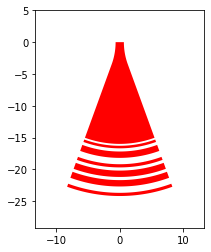

In [40]:
import numpy as np
from math import pi
from gdshelpers.geometry.chip import Cell
from gdshelpers.parts.waveguide import Waveguide

coupler_params = {
    'width': 1.3,
    'full_opening_angle': np.deg2rad(40),
    'grating_period': 1.155,
    'grating_ff': 0.85,
    'n_gratings': 20,
    'taper_length': 16.,
    'implement_cadence_ff_bug': False,
    'custom_inputs': [0.3, 0.4, 0.5, 1.0, 1.0, 0.5, 0.5, 1.0, 0.5, 1.0, 1.0, 0.5]
}

left_coupler = GratingCoupler2.make_traditional_coupler(origin=(0, 0), **coupler_params)
"""
wg = Waveguide.make_at_port(port=left_coupler.port)
wg.add_straight_segment(length=10)
wg.add_bend(angle=-pi / 2, radius=50)
wg.add_straight_segment(length=150)
wg.add_bend(angle=-pi / 2, radius=50)
wg.add_straight_segment(length=10)
right_coupler = GratingCoupler.make_traditional_coupler_at_port(port=wg.current_port, **coupler_params)
"""

cell = Cell('SIMPLE_DEVICE')
cell.add_to_layer(1, left_coupler)
cell.show()
# cell.save('chip.gds')